In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import os
import shutil
import yaml

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/DeepLearning/dataset/bbgt.zip" -d "/content/drive/MyDrive/DeepLearning/dataset"

K·∫øt qu·∫£ truy·ªÅn tr·ª±c tuy·∫øn b·ªã c·∫Øt b·ªõt ƒë·∫øn 5000 d√≤ng cu·ªëi.
 extracting: /content/drive/MyDrive/DeepLearning/dataset/train/labels/3580_png.rf.fcd7e876305e6870f9b71103e2cd607e.txt  
 extracting: /content/drive/MyDrive/DeepLearning/dataset/train/labels/3582_png.rf.9657b8aba7bb040b88a62e3f9fb79f84.txt  
 extracting: /content/drive/MyDrive/DeepLearning/dataset/train/labels/3582_png.rf.ad708415116f2ef4131560633b06b380.txt  
 extracting: /content/drive/MyDrive/DeepLearning/dataset/train/labels/3590_png.rf.8726ee88487b076db9b73ad92826be94.txt  
 extracting: /content/drive/MyDrive/DeepLearning/dataset/train/labels/3590_png.rf.a0ca4d4e00fae9d2f076fced193dfc80.txt  
 extracting: /content/drive/MyDrive/DeepLearning/dataset/train/labels/3592_png.rf.65173e70a33f6e4eea11c2a3627139b6.txt  
 extracting: /content/drive/MyDrive/DeepLearning/dataset/train/labels/3592_png.rf.de2f943b46fb327d89b1810e4a5b97d7.txt  
 extracting: /content/drive/MyDrive/DeepLearning/dataset/train/labels/3593

In [ ]:
# STEP 1: TAI DU LIEU DATASET
dataset_path = "/content/drive/MyDrive/DeepLearning/dataset"
# ƒê·ªçc file data.yaml
yaml_path = os.path.join(dataset_path, "data.yaml")
with open(yaml_path, "r") as f:
    data = yaml.safe_load(f)
    classes = data.get("names", [])  # L·∫•y danh s√°ch nh√£n

print("‚úÖ Danh s√°ch class:", classes)


‚úÖ Danh s√°ch class: ['Cam con lai', 'Cam dung va do', 'Cam nguoc chieu', 'Cam re', 'Gioi han toc do', 'Hieu lenh', 'Nguy hiem']


In [ ]:
dataset_path = "/content/drive/MyDrive/DeepLearning/dataset"

for split in ["train", "valid", "test"]:
    img_dir = os.path.join(dataset_path, split, "images")
    label_dir = os.path.join(dataset_path, split, "labels")

    if not os.path.exists(img_dir):
        print(f"‚ùå Kh√¥ng t√¨m th·∫•y th∆∞ m·ª•c {img_dir}")
    else:
        print(f"üìÇ {split}/images: {len(os.listdir(img_dir))} ·∫£nh")

    if not os.path.exists(label_dir):
        print(f"‚ùå Kh√¥ng t√¨m th·∫•y th∆∞ m·ª•c {label_dir}")
    else:
        print(f"üìÑ {split}/labels: {len(os.listdir(label_dir))} file nh√£n")


üìÇ train/images: 6390 ·∫£nh
üìÑ train/labels: 6390 file nh√£n
üìÇ valid/images: 433 ·∫£nh
üìÑ valid/labels: 433 file nh√£n
üìÇ test/images: 317 ·∫£nh
üìÑ test/labels: 317 file nh√£n


In [ ]:
dataset_path = "/content/drive/MyDrive/DeepLearning/dataset"
output_path = "/content/drive/MyDrive/DeepLearning/dataset_classification"
os.makedirs(output_path, exist_ok=True)

# Load danh s√°ch nh√£n t·ª´ data.yaml
yaml_path = os.path.join(dataset_path, "data.yaml")
with open(yaml_path, "r") as f:
    data = yaml.safe_load(f)
    classes = data.get("names", [])

def convert_dataset(split):
    img_dir = os.path.join(dataset_path, split, "images")
    label_dir = os.path.join(dataset_path, split, "labels")

    # Ki·ªÉm tra n·∫øu th∆∞ m·ª•c kh√¥ng t·ªìn t·∫°i
    if not os.path.exists(img_dir) or not os.path.exists(label_dir):
        print(f"‚ö†Ô∏è B·ªè qua {split} v√¨ thi·∫øu th∆∞ m·ª•c ·∫£nh ho·∫∑c nh√£n.")
        return

    print(f"üîÑ Chuy·ªÉn ƒë·ªïi {split}...")

    for label_file in os.listdir(label_dir):
        label_path = os.path.join(label_dir, label_file)
        img_name = label_file.replace(".txt", ".jpg")  # ƒê·ªïi ƒëu√¥i file nh√£n sang ·∫£nh
        img_path = os.path.join(img_dir, img_name)

        # Ki·ªÉm tra n·∫øu ·∫£nh kh√¥ng t·ªìn t·∫°i
        if not os.path.exists(img_path):
            print(f"‚ùå Kh√¥ng t√¨m th·∫•y ·∫£nh: {img_path}, b·ªè qua.")
            continue

        # ƒê·ªçc file nh√£n
        with open(label_path, "r") as f:
            lines = f.readlines()

        # N·∫øu file nh√£n r·ªóng, b·ªè qua
        if len(lines) == 0:
            print(f"‚ö†Ô∏è File {label_path} tr·ªëng, b·ªè qua.")
            continue

        # L·∫•y class ID t·ª´ d√≤ng ƒë·∫ßu ti√™n
        class_id = int(lines[0].split()[0])

        # Ki·ªÉm tra class ID h·ª£p l·ªá
        if class_id >= len(classes):
            print(f"‚ùå L·ªói: Class ID {class_id} v∆∞·ª£t qu√° s·ªë l∆∞·ª£ng l·ªõp.")
            continue

        class_name = classes[class_id]

        # T·∫°o th∆∞ m·ª•c n·∫øu ch∆∞a c√≥
        class_path = os.path.join(output_path, split, class_name)
        os.makedirs(class_path, exist_ok=True)

        # Copy ·∫£nh v√†o th∆∞ m·ª•c class
        shutil.copy(img_path, os.path.join(class_path, img_name))

    print(f"‚úÖ Ho√†n th√†nh chuy·ªÉn ƒë·ªïi {split}!")

# Chuy·ªÉn ƒë·ªïi c·∫£ 3 t·∫≠p d·ªØ li·ªáu
convert_dataset("train")
convert_dataset("valid")
convert_dataset("test")

print("‚úÖ Dataset ƒë√£ chuy·ªÉn ƒë·ªïi xong!")


üîÑ Chuy·ªÉn ƒë·ªïi train...
‚ö†Ô∏è File /content/drive/MyDrive/DeepLearning/dataset/train/labels/10027_png.rf.36132ab3c22e1547960cb4a2d0c45b5c.txt tr·ªëng, b·ªè qua.
‚ö†Ô∏è File /content/drive/MyDrive/DeepLearning/dataset/train/labels/10027_png.rf.e3e58effcb67a2eb6dba506ad46c78c1.txt tr·ªëng, b·ªè qua.
‚ö†Ô∏è File /content/drive/MyDrive/DeepLearning/dataset/train/labels/10028_png.rf.236bca71f7dc393277f2b5f00607227d.txt tr·ªëng, b·ªè qua.
‚ö†Ô∏è File /content/drive/MyDrive/DeepLearning/dataset/train/labels/10063_png.rf.628e5f555136b70f6ff123653ab36aa8.txt tr·ªëng, b·ªè qua.
‚ö†Ô∏è File /content/drive/MyDrive/DeepLearning/dataset/train/labels/10063_png.rf.6850265e7be745358f40b4c10c9bac5b.txt tr·ªëng, b·ªè qua.
‚ö†Ô∏è File /content/drive/MyDrive/DeepLearning/dataset/train/labels/10066_png.rf.19b178ec779aa2dc141aa6f35f311546.txt tr·ªëng, b·ªè qua.
‚ö†Ô∏è File /content/drive/MyDrive/DeepLearning/dataset/train/labels/10066_png.rf.b64d1fda141ce3d12bc2dce443fc3686.txt tr·ªëng, b·ªè qua.
‚ö†Ô

In [ ]:
output_path = "/content/drive/MyDrive/DeepLearning/dataset_classification"

for split in ["train", "valid", "test"]:
    split_path = os.path.join(output_path, split)
    if os.path.exists(split_path):
        num_classes = len(os.listdir(split_path))
        total_images = sum([len(os.listdir(os.path.join(split_path, class_name))) for class_name in os.listdir(split_path)])
        print(f"üìÇ {split}: {num_classes} l·ªõp, {total_images} ·∫£nh")
    else:
        print(f"‚ùå Kh√¥ng t√¨m th·∫•y th∆∞ m·ª•c {split}")

üìÇ train: 7 l·ªõp, 6049 ·∫£nh
üìÇ valid: 7 l·ªõp, 410 ·∫£nh
üìÇ test: 7 l·ªõp, 299 ·∫£nh


In [ ]:
# ƒê·ªãnh nghƒ©a ƒë∆∞·ªùng d·∫´n
train_dir = "/content/drive/MyDrive/DeepLearning/dataset_classification/train"
valid_dir = "/content/drive/MyDrive/DeepLearning/dataset_classification/valid"
test_dir = "/content/drive/MyDrive/DeepLearning/dataset_classification/test"

# K√≠ch th∆∞·ªõc ·∫£nh ƒë·∫ßu v√†o
IMG_SIZE = (128, 128)  # Resize ·∫£nh v·ªÅ 128x128
BATCH_SIZE = 32

# T·∫°o ImageDataGenerator ƒë·ªÉ load ·∫£nh t·ª´ th∆∞ m·ª•c
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load d·ªØ li·ªáu t·ª´ th∆∞ m·ª•c
train_data = train_datagen.flow_from_directory(
    train_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False
)

valid_data = valid_datagen.flow_from_directory(
    valid_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False
)

test_data = test_datagen.flow_from_directory(
    test_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False
)

# L·∫•y to√†n b·ªô d·ªØ li·ªáu t·ª´ generator v√† chuy·ªÉn th√†nh numpy array
X_train, y_train = next(train_data)
X_test, y_test = next(test_data)

# In th√¥ng tin d·ªØ li·ªáu
print(f"‚úÖ X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"‚úÖ X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


Found 6049 images belonging to 7 classes.
Found 410 images belonging to 7 classes.
Found 299 images belonging to 7 classes.
‚úÖ X_train shape: (32, 128, 128, 3), y_train shape: (32, 7)
‚úÖ X_test shape: (32, 128, 128, 3), y_test shape: (32, 7)


In [ ]:
# L·∫•y to√†n b·ªô d·ªØ li·ªáu train
X_train, y_train = [], []
for _ in range(len(train_data)):
    X, y = next(train_data)  # D√πng next() thay v√¨ .next()
    X_train.append(X)
    y_train.append(y)

# Chuy·ªÉn th√†nh numpy array
X_train = np.vstack(X_train)
y_train = np.vstack(y_train)
print(f"‚úÖ D·ªØ li·ªáu train ƒë·∫ßy ƒë·ªß: {X_train.shape}, {y_train.shape}")

In [ ]:
# L·∫•y to√†n b·ªô d·ªØ li·ªáu test
X_test, y_test = [], []
for _ in range(len(test_data)):
    X, y = next(test_data)  # D√πng next() thay v√¨ .next()
    X_test.append(X)
    y_test.append(y)

# Chuy·ªÉn th√†nh numpy array
X_test = np.vstack(X_test)
y_test = np.vstack(y_test)
print(f"‚úÖ D·ªØ li·ªáu test ƒë·∫ßy ƒë·ªß: {X_test.shape}, {y_test.shape}")

‚úÖ D·ªØ li·ªáu test ƒë·∫ßy ƒë·ªß: (299, 128, 128, 3), (299, 7)


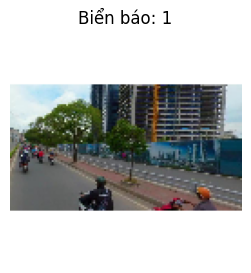

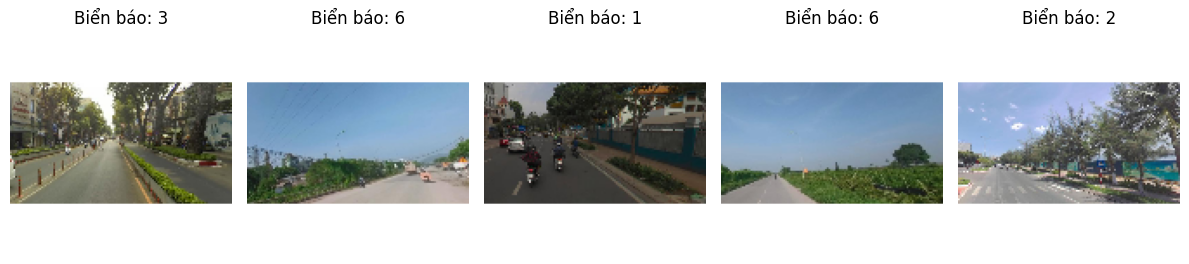

In [ ]:
#STEP 2: HIEN THI MOT SO ANH VI DU
idx = 1500

plt.figure(figsize=(6, 3))
plt.imshow(X_train[idx])  # Hi·ªÉn th·ªã ·∫£nh m√†u
plt.title(f"Bi·ªÉn b√°o: {np.argmax(y_train[idx])}", fontsize=12)
  # Chuy·ªÉn t·ª´ one-hot v·ªÅ s·ªë nguy√™n
plt.axis('off')  # ·∫®n tr·ª•c t·ªça ƒë·ªô
plt.show()



# Hi·ªÉn th·ªã th√™m 5 v√≠ d·ª• kh√°c
plt.figure(figsize=(12, 4))
num_images = 5
for i in range(num_images):
    idx = np.random.randint(1, 6049)  # Ch·ªçn ng·∫´u nhi√™n ch·ªâ s·ªë t·ª´ 1 ƒë·∫øn 6000
    plt.subplot(1, num_images, i+1)
    plt.imshow(X_train[idx])
    plt.title(f"Bi·ªÉn b√°o: {np.argmax(y_train[idx])}", fontsize=12)
    plt.axis('off')
plt.tight_layout()
plt.show()


In [ ]:
# STEP 1: X√ÇY D·ª∞NG M√î H√åNH CNN (S·ª¨A L·∫†I CHO 7 L·ªöP)
NUM_CLASSES = 7  # S·ªë l·ªõp th·ª±c t·∫ø
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation='softmax')  # S·ª≠a t·ª´ 2 th√†nh 7 l·ªõp
])

# Bi√™n d·ªãch m√¥ h√¨nh
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_2"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                         ‚îÉ Output Shape                ‚îÉ         Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ conv2d_6 (Conv2D)                    ‚îÇ (None, 126, 126, 32)        ‚îÇ             896 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ max_pooling2d_6 (MaxPooling2D)       ‚îÇ (None, 63, 63, 32)          ‚îÇ               0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv2d_7 (Conv2D)                    ‚îÇ (None, 61, 61, 64)          ‚îÇ          18,496 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ max_pooling2d_7 (MaxPooling2D)       ‚îÇ (None, 30, 30, 64)          ‚îÇ               0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv2d_8 (Conv2D)                    ‚îÇ (None, 28, 28, 128)         ‚îÇ          73,856 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ max_pooling2d_8 (MaxPooling2D)       ‚îÇ (None, 14, 14, 128)         ‚îÇ               0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ flatten_2 (Flatten)                  ‚îÇ (None, 25088)               ‚îÇ               0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_4 (Dense)                      ‚îÇ (None, 128)                 ‚îÇ       3,211,392 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_2 (Dropout)                  ‚îÇ (None, 128)                 ‚îÇ               0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_5 (Dense)                      ‚îÇ (None, 7)                   ‚îÇ             903 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ

 Total params: 3,305,543 (12.61 MB)

 Trainable params: 3,305,543 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# STEP 2: HU·∫§N LUY·ªÜN M√î H√åNH
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_test, y_test)
)

Epoch 1/10
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 7s 7s/step - accuracy: 0.1875 - loss: 1.8482 - val_accuracy: 1.0000 - val_loss: 0.0033
Epoch 2/10
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 131ms/step - accuracy: 1.0000 - loss: 0.0149 - val_accuracy: 1.0000 - val_loss: 5.7369e-07
Epoch 3/10
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 128ms/step - accuracy: 1.0000 - loss: 4.0249e-05 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 4/10
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 160ms/step - accuracy: 1.0000 - loss: 1.1325e-06 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 5/10
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 294ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 6/10
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 152ms/step - accuracy: 1.0000 - loss: 7.4506e-09 - val_accuracy: 1

1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 45ms/step - accuracy: 1.0000 - loss: 0.0000e+00
‚úÖ Test accuracy: 100.00%


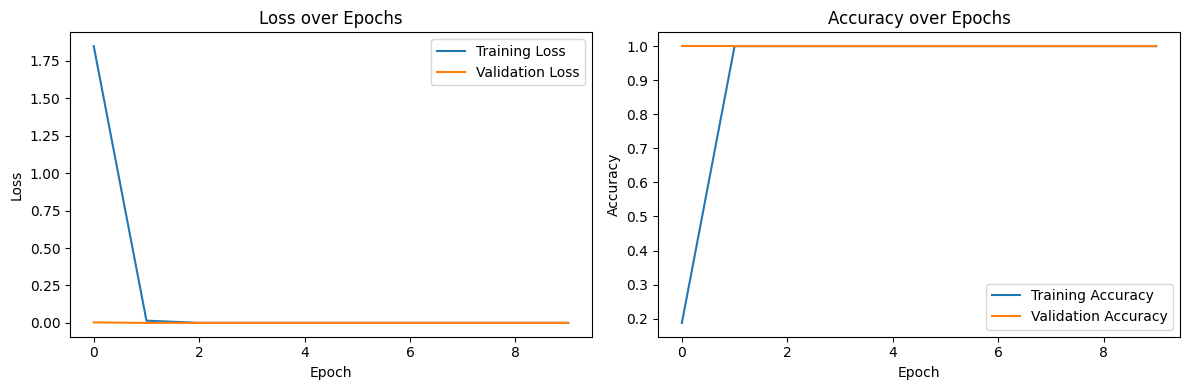

In [ ]:
# STEP 3: ƒê√ÅNH GI√Å M√î H√åNH
loss, accuracy = model.evaluate(X_test, y_test)
print(f"‚úÖ Test accuracy: {accuracy*100:.2f}%")

# STEP 4: V·∫º ƒê·ªí TH·ªä HI·ªÜU SU·∫§T
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# STEP 5: D·ª∞ ƒêO√ÅN V√Ä HI·ªÇN TH·ªä K·∫æT QU·∫¢ M·∫™U (CH·ªåN T·ª™ X_test)
indices = np.random.randint(0, 299, 5)  # Ch·ªçn ng·∫´u nhi√™n 5 ch·ªâ s·ªë t·ª´ 1 ƒë·∫øn 317
X_sample = X_test[indices]
y_sample_true = y_test[indices]
y_sample_pred = model.predict(X_sample)

plt.figure(figsize=(15, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(X_sample[i])
    true_label = np.argmax(y_sample_true[i])
    pred_label = np.argmax(y_sample_pred[i])
    plt.title(f"True: {true_label}\nPred: {pred_label}")
    plt.axis('off')
plt.tight_layout()
plt.show()

IndexError: index 272 is out of bounds for axis 0 with size 32

In [ ]:
# STEP 6: L∆ØU M√î H√åNH
model.save('/content/drive/MyDrive/DeepLearning/traffic_sign_cnn_7classes.h5')
print("‚úÖ M√¥ h√¨nh ƒë√£ ƒë∆∞·ª£c l∆∞u t·∫°i: /content/drive/MyDrive/DeepLearning/traffic_sign_cnn_7classes.h5")